# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)
ignored = list()

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        if movie_plot == 'N/A':
            ignored.append(movie_id)
            continue
        items[movie_id] = movie_plot

print('Number of movies: {:,d}'.format(len(items)))
print('Number of N/A: {:,d}'.format(len(ignored)))

Number of movies: 9,106
Number of N/A: 19


In [2]:
from scipy import stats

sizes = list(len(movie_plot) for movie_plot in items.values())
stats.describe(sizes)

DescribeResult(nobs=9106, minmax=(17, 5585), mean=432.19646386997584, variance=124206.00763603917, skewness=2.217817524586907, kurtosis=10.294480522289218)

In [3]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [4]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Workspace/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

El Dorado (1966)

Hired gunman Cole Thornton turns down a job with Bart Jason as it would mean having to fight an old sheriff friend. Some months later he finds out the lawman is on the bottle and a top gunfighter is heading his way to help Jason. Along with young Mississippi, handy with a knife and now armed with a diabolical shotgun, Cole returns to help.

['hired', 'gunman', 'cole', 'thornton', 'turns', 'down', 'a', 'job', 'with', 'bart', 'jason', 'as', 'it', 'would', 'mean', 'having', 'to', 'fight', 'an', 'old', 'sheriff', 'friend', '.', 'some', 'months', 'later', 'he', 'finds', 'out', 'the', 'lawman', 'is', 'on', 'the', 'bottle', 'and', 'a', 'top', 'gunfighter', 'is', 'heading', 'his', 'way', 'to', 'help', 'jason', '.', 'along', 'with', 'young', 'mississippi', ',', 'handy', 'with', 'a', 'knife', 'and', 'now', 'armed', 'with', 'a', 'diabolical', 'shotgun', ',', 'cole', 'returns', 'to', 'help', '.']

Inland Empire (2006)

As an actress starts to adopt the persona of her character in

In [6]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

38387

Documents size:

9106

Most common words (+UNK):

[(',', 39543), ('the', 37983), ('.', 29809), ('a', 24721), ('to', 22220)]

Document example: id=3487

El Dorado (1966) 

Hired gunman Cole Thornton turns down a job with Bart Jason as it would mean having to fight an old sheriff friend. Some months later he finds out the lawman is on the bottle and a top gunfighter is heading his way to help Jason. Along with young Mississippi, handy with a knife and now armed with a diabolical shotgun, Cole returns to help. 

[584, 6506, 2598, 9733, 289, 149, 4, 136, 13, 4505, 1111, 19, 31, 201, 1670, 194, 5, 260, 20, 102, 925, 101, 3, 104, 652, 193, 11, 73, 38, 2, 6963, 9, 18, 2, 3897, 6, 4, 558, 5871, 9, 2739, 10, 88, 5, 84, 1111, 3, 199, 13, 53, 3603, 1, 12771, 13, 4, 5923, 6, 97, 1381, 13, 4, 5650, 5474, 1, 2598, 266, 5, 84, 3] 

['hired', 'gunman', 'cole', 'thornton', 'turns', 'down', 'a', 'job', 'with', 'bart', 'jason', 'as', 'it', 'would', 'mean', 'having', 'to', 'fight'

In [7]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (6506, gunman) -> (2598, cole)
0: (6506, gunman) -> (584, hired)
0: (2598, cole) -> (9733, thornton)
0: (2598, cole) -> (6506, gunman)
0: (9733, thornton) -> (2598, cole)
0: (9733, thornton) -> (289, turns)
0: (289, turns) -> (9733, thornton)
0: (289, turns) -> (149, down)
0: (149, down) -> (4, a)
0: (149, down) -> (289, turns)

2nd Batch:

0: (4, a) -> (149, down)
0: (4, a) -> (136, job)
0: (136, job) -> (13, with)
0: (136, job) -> (4, a)
0: (13, with) -> (4505, bart)
0: (13, with) -> (136, job)
0: (4505, bart) -> (1111, jason)
0: (4505, bart) -> (13, with)
0: (1111, jason) -> (4505, bart)
0: (1111, jason) -> (19, as)

3rd Batch:

0: (19, as) -> (31, it)
0: (19, as) -> (1111, jason)
0: (31, it) -> (19, as)
0: (31, it) -> (201, would)
0: (201, would) -> (1670, mean)
0: (201, would) -> (31, it)
0: (1670, mean) -> (194, having)
0: (1670, mean) -> (201, would)
0: (194, having) -> (5, to)
0: (194, having) -> (1670, mean)


In [8]:
import tensorflow as tf
import shutil

class Paragraph2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width),
            name='docs_embeddings')
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width),
            name='words_embeddings')
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self._lr = tf.Variable(self.learning_rate, trainable=False)
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        global_step = tf.Variable(0, name='global_step', trainable=False)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._lr)
        #self.train = optimizer.minimize(self.loss, global_step=global_step, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss, global_step=global_step)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm

    def lr(self, session):
        return session.run(self._lr)
    
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})


class NearestWordsQuery:
    
    def __init__(self, model, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(model.words_embeddings, input_words)
        similarity = tf.matmul(words_embeddings, model.words_embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, model, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(model.docs_embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, model.docs_embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}\n\n{}\n'.format(n, near_sim, near_title, near_text))
            print('---\n')


class Paragraph2vecTrainer:
    
    #dataset
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 learning_rate,
                 logdir='log/paragraph2vec'):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        self.logdir = logdir
    
    def remove_log(self):
        shutil.rmtree(self.logdir)
    
    def train(self, num_epochs=1, delay_lr_decay=0, reset_log=True):
        if reset_log:
            self.remove_log()
        
        data_reader = self.data_reader()
        
        with tf.Graph().as_default():
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            sv = tf.train.Supervisor(logdir=self.logdir)
            with sv.managed_session() as session:
                train_ops = [model.train, model.loss]
                average_loss = 0
            
                step = 0
                last_epoch = data_reader.num_epoch
                while data_reader.num_epoch < num_epochs:
                    batch_docs, batch_data, batch_labels = data_reader.read()
                    feed_dict = {
                        model.input_docs: batch_docs,
                        model.input_data: batch_data,
                        model.input_labels: batch_labels,
                    }
                
                    _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                    average_loss += loss_val

                    if step % 5000 == 0:
                        if step > 0:
                            average_loss /= 5000
                        print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                        average_loss = 0
                                
                    step += 1
                
                    if data_reader.num_epoch != last_epoch:
                        last_epoch = data_reader.num_epoch

                        lr = model.lr(session)
                        if last_epoch >= delay_lr_decay:
                            model.assign_lr(session, max(0.00001, lr / 2))
                    
                        print()
                        print('Epoch {} (lr={:,.5f})'.format(last_epoch, lr))
                        print()
                        doc_query.run(session)
                        word_query.run(session)
                        print()

                print('Total steps: {:,d}'.format(step))
            
                docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Paragraph2vecModel(self.corpus.documents_size,
                                  self.corpus.vocabulary_size,
                                  self.embedding_size,
                                  self.num_sampled,
                                  self.learning_rate)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)


In [9]:
%%time

trainer = Paragraph2vecTrainer(
    train_corpus,
    batch_size = 16,
    skip_window = 2,       # How many words to consider left and right.
    num_skips = 2,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 100,     # Number of negative examples to sample.
    learning_rate = 0.2)   # Initial learning rate.

docs_embeddings = trainer.train(num_epochs=25, delay_lr_decay=20)
# docs_embeddings = trainer.train(num_epochs=1)

INFO:tensorflow:global_step/sec: 0
Average loss at step 0: 379.464
Average loss at step 5,000: 76.282
Average loss at step 10,000: 25.443
Average loss at step 15,000: 18.941
Average loss at step 20,000: 17.335
Average loss at step 25,000: 14.958
Average loss at step 30,000: 13.856
Average loss at step 35,000: 13.656
Average loss at step 40,000: 12.879
INFO:tensorflow:global_step/sec: 342.699
Average loss at step 45,000: 12.259
Average loss at step 50,000: 11.876
Average loss at step 55,000: 10.865
Average loss at step 60,000: 10.876
Average loss at step 65,000: 10.484
Average loss at step 70,000: 10.379
Average loss at step 75,000: 10.318
Average loss at step 80,000: 9.591
INFO:tensorflow:global_step/sec: 339.216
Average loss at step 85,000: 10.004
Average loss at step 90,000: 9.280

Epoch 1 (lr=0.20000)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the 

Average loss at step 280,000: 6.104
Average loss at step 285,000: 5.743
INFO:tensorflow:global_step/sec: 342.267
Average loss at step 290,000: 5.544
Average loss at step 295,000: 5.432
Average loss at step 300,000: 5.324
Average loss at step 305,000: 5.288
Average loss at step 310,000: 5.274
Average loss at step 315,000: 5.237
Average loss at step 320,000: 5.201
Average loss at step 325,000: 5.178
INFO:tensorflow:global_step/sec: 343.816
Average loss at step 330,000: 5.153
Average loss at step 335,000: 5.127
Average loss at step 340,000: 5.131
Average loss at step 345,000: 5.134
Average loss at step 350,000: 5.113
Average loss at step 355,000: 5.095
Average loss at step 360,000: 5.100
Average loss at step 365,000: 5.067

Epoch 4 (lr=0.20000)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the gun and used it to shoot his abusive father. Now Joey has to fin

Average loss at step 575,000: 4.756
Average loss at step 580,000: 4.737
Average loss at step 585,000: 4.728
Average loss at step 590,000: 4.709
Average loss at step 595,000: 4.681
Average loss at step 600,000: 4.654
Average loss at step 605,000: 4.661
Average loss at step 610,000: 4.642
Average loss at step 615,000: 4.622
Average loss at step 620,000: 4.639
Average loss at step 625,000: 4.632
Average loss at step 630,000: 4.609
Average loss at step 635,000: 4.619
Average loss at step 640,000: 4.583

Epoch 7 (lr=0.20000)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the gun and used it to shoot his abusive father. Now Joey has to find that kid and the gun before the police and the mob do.

[ 1, 0.925 ] Sholay (1975)

After his family is murdered by a notorious and ruthless bandit, a former police officer enlists the services of two outlaws to capture the 

Average loss at step 920,000: 4.203
Average loss at step 925,000: 4.259
Average loss at step 930,000: 4.208
Average loss at step 935,000: 4.171
Average loss at step 940,000: 4.172
Average loss at step 945,000: 4.149
Average loss at step 950,000: 4.143
Average loss at step 955,000: 4.122
Average loss at step 960,000: 4.105
Average loss at step 965,000: 4.119
Average loss at step 970,000: 4.094
Average loss at step 975,000: 4.090
Average loss at step 980,000: 4.088
Average loss at step 985,000: 4.084
Average loss at step 990,000: 4.067
Average loss at step 995,000: 4.078
Average loss at step 1,000,000: 4.062
Average loss at step 1,005,000: 4.056

Epoch 11 (lr=0.20000)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the gun and used it to shoot his abusive father. Now Joey has to find that kid and the gun before the police and the mob do.

[ 1, 0.822 ] Blue T

Average loss at step 1,285,000: 3.799
Average loss at step 1,290,000: 3.856
Average loss at step 1,295,000: 3.794
Average loss at step 1,300,000: 3.808
Average loss at step 1,305,000: 3.794
Average loss at step 1,310,000: 3.769
Average loss at step 1,315,000: 3.789
Average loss at step 1,320,000: 3.761
Average loss at step 1,325,000: 3.751
Average loss at step 1,330,000: 3.760
Average loss at step 1,335,000: 3.725
Average loss at step 1,340,000: 3.778
Average loss at step 1,345,000: 3.747
Average loss at step 1,350,000: 3.731
Average loss at step 1,355,000: 3.710
Average loss at step 1,360,000: 3.735
Average loss at step 1,365,000: 3.710
Average loss at step 1,370,000: 3.709
Average loss at step 1,375,000: 3.751

Epoch 15 (lr=0.20000)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the gun and used it to shoot his abusive father. Now Joey has to find that 

Average loss at step 1,655,000: 3.627
Average loss at step 1,660,000: 3.635
Average loss at step 1,665,000: 3.594
Average loss at step 1,670,000: 3.594
Average loss at step 1,675,000: 3.592
Average loss at step 1,680,000: 3.626
Average loss at step 1,685,000: 3.581
Average loss at step 1,690,000: 3.561
Average loss at step 1,695,000: 3.563
Average loss at step 1,700,000: 3.559
Average loss at step 1,705,000: 3.597
Average loss at step 1,710,000: 3.584
Average loss at step 1,715,000: 3.554
Average loss at step 1,720,000: 3.545
Average loss at step 1,725,000: 3.548
Average loss at step 1,730,000: 3.560
Average loss at step 1,735,000: 3.513
Average loss at step 1,740,000: 3.534

Epoch 19 (lr=0.20000)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the gun and used it to shoot his abusive father. Now Joey has to find that kid and the gun before the police and 

Average loss at step 2,020,000: 3.040
Average loss at step 2,025,000: 3.057
Average loss at step 2,030,000: 3.012
Average loss at step 2,035,000: 3.008
Average loss at step 2,040,000: 3.027
Average loss at step 2,045,000: 3.004
Average loss at step 2,050,000: 3.019
Average loss at step 2,055,000: 2.994
Average loss at step 2,060,000: 2.974
Average loss at step 2,065,000: 2.995
Average loss at step 2,070,000: 2.990
Average loss at step 2,075,000: 2.990
Average loss at step 2,080,000: 3.006
Average loss at step 2,085,000: 2.962
Average loss at step 2,090,000: 2.965
Average loss at step 2,095,000: 2.967
Average loss at step 2,100,000: 2.930
Average loss at step 2,105,000: 2.939

Epoch 23 (lr=0.02500)

Running Scared (2006)

After a drug-op gone bad, Joey Gazelle is put in charge of disposing the gun that shot a dirty cop. But things go wrong for Joey after a neighbor kid stole the gun and used it to shoot his abusive father. Now Joey has to find that kid and the gun before the police and 

In [10]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(docs_embeddings)
labels = list(train_corpus.document_from_idx[i] for i in range(docs_embeddings.shape[0]))

CPU times: user 2min 35s, sys: 29.4 s, total: 3min 4s
Wall time: 2min 57s


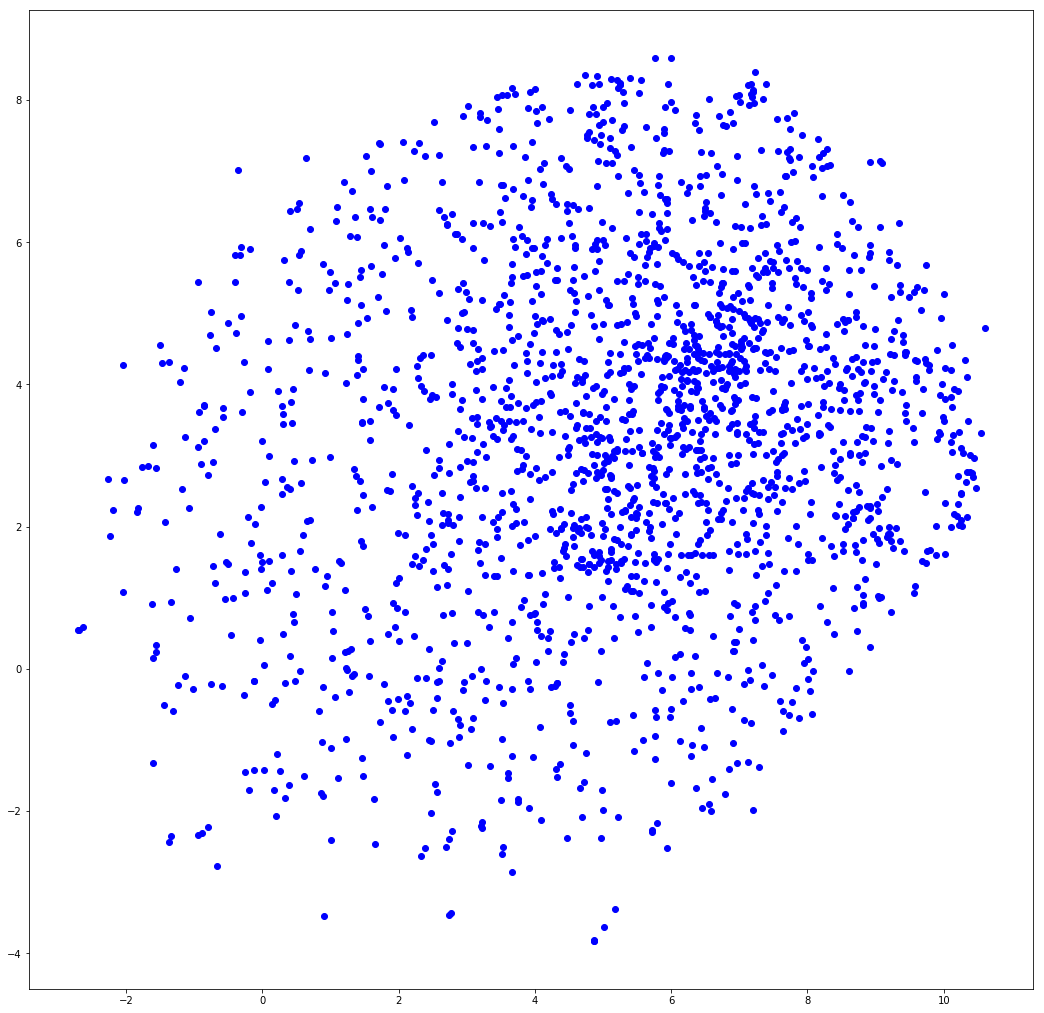

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

points = np.random.choice(len(labels), 2000, replace=False)

plt.figure(figsize=(18, 18))  #in inches
for i in points:
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y, color='b')
    #label = labels[i]
    #plt.annotate(
    #    label,
    #    xy=(x, y),
    #    xytext=(5, 2),
    #    textcoords='offset points',
    #    ha='right',
    #    va='bottom')

plt.show()

### Content-based User-Item: Avarage with Time Decay

In [12]:
import collections
import csv

MovieWatch = collections.namedtuple('MovieWatch', ['movie_id', 'timestamp'])

users = collections.defaultdict(list)
with open('movielens/ml-latest-small/ratings.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for user_id, item_id, _, timestamp in reader:
        users[user_id].append(MovieWatch(item_id, int(timestamp)))

len(users)

671

In [13]:
from scipy import stats

watch_counts = list(len(movies) for movies in users.values())
stats.describe(watch_counts)

DescribeResult(nobs=671, minmax=(20, 2391), mean=149.03725782414307, variance=53465.901594857307, skewness=4.544628118876828, kurtosis=28.187338511028905)

In [14]:
user_items = dict()
for user, movies in users.items():
    items = list()
    movies = sorted(movies, key=lambda m: int(m.timestamp))
    for movie_id, _ in movies:
        if movie_id not in train_corpus.document_to_idx:
            continue
        i = train_corpus.document_to_idx[movie_id]
        items.append(i)
    user_items[user] = items

stats.describe(list(len(items) for items in user_items.values()))

DescribeResult(nobs=671, minmax=(20, 2390), mean=149.00745156482861, variance=53434.46113842116, skewness=4.543685375623357, kurtosis=28.17545840836149)

In [15]:
class Recommender:
    
    def __init__(self, item_embeddings, user_items, mapping, decay):
        self.item_embeddings = item_embeddings
        n_items = item_embeddings.shape[0]
        
        self.user_items = user_items
        self.user_u = dict()
        self.user_t = collections.defaultdict(int)
        self.user_h = collections.defaultdict(lambda: np.zeros(n_items))
        
        self.mapping = mapping
        self.decay = decay
    
    def user_vec(self, user_id, t):
        items = self.user_items[user_id]
        
        if t >= len(items):
            return self.user_u[user_id], self.user_h[user_id]
        
        i = items[t]
        v = self.item_embeddings[i]
        if t == 0:
            u = v
        else:
            u = v + self.decay * self.user_u[user_id]
            u = u / np.linalg.norm(u)
        self.user_u[user_id] = u
        h = self.user_h[user_id]
        h[i] = 1
        
        return u, h
        
    def recommend(self, user_id, k=3):
        if user_id not in self.user_items:
            return None
        
        t = self.user_t[user_id]
        self.user_t[user_id] += 1
        
        u, h = self.user_vec(user_id, t)
        
        d = np.dot(self.item_embeddings, u)
        d = np.multiply(d, 1 - h)
        rank = d.argsort()[::-1][:k]
        
        return list(self.mapping.document_from_idx[i] for i in rank)

In [16]:
user_id, items = list(user_items.items())[0]

print('{} (movies = {:,d})'.format(user_id, len(items)))
print()

rec = Recommender(docs_embeddings, user_items, train_corpus, 0.8)

for k, last_item in enumerate(items):
    print(train_corpus.title_from_idx(last_item))
    rec_items = rec.recommend(user_id)
    if k < len(items) - 10:
        continue
    print()
    for i, item_id in enumerate(rec_items):
        print('[ {} ] {}'.format(i+1, train_corpus.title_from_id(item_id)))
    print()

182 (movies = 131)

Apollo 13 (1995)
True Lies (1994)
Dances with Wolves (1990)
Die Hard: With a Vengeance (1995)
Ace Ventura: Pet Detective (1994)
Silence of the Lambs, The (1991)
Dumb & Dumber (Dumb and Dumber) (1994)
Stargate (1994)
Clear and Present Danger (1994)
Fugitive, The (1993)
Forrest Gump (1994)
Jurassic Park (1993)
Waterworld (1995)
Outbreak (1995)
While You Were Sleeping (1995)
Firm, The (1993)
Braveheart (1995)
Net, The (1995)
Lion King, The (1994)
Speed (1994)
Terminator 2: Judgment Day (1991)
Babe (1995)
Quiz Show (1994)
Addams Family Values (1993)
Mrs. Doubtfire (1993)
Get Shorty (1995)
Disclosure (1994)
Sleepless in Seattle (1993)
Ghost (1990)
Legends of the Fall (1994)
Santa Clause, The (1994)
Four Weddings and a Funeral (1994)
Dave (1993)
American President, The (1995)
Client, The (1994)
City Slickers II: The Legend of Curly's Gold (1994)
Jumanji (1995)
Nell (1994)
Sense and Sensibility (1995)
Broken Arrow (1996)
French Kiss (1995)
Tombstone (1993)
Birdcage, The (1